# Movie CFO

## Introduction to the tool

We will create a new class MovieCFO which will help us to process the historical movie data to project the gross revenue for the upcoming movies and compute whether the movie will be profitable with the following assumption:

$$ \text{Gross Margin} = \frac{\text{Gross Revenue} - \text{Budget}}{\text{Gross Revenue}} $$

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests

from scipy.stats import f_oneway

pd.options.display.max_columns = None

## Movie Director's Office

In [84]:
class MDO():
    """Base class for the Movie Director Office (MDO) project.
    It helps to prepare and clean the data to be used by the various other classes.

    Attributes
    ----------
    pre : pd.DataFrame
        Pre-release dataset
    after : pd.DataFrame
        After-release dataset
    full : pd.DataFrame
        Merged dataset
    pred_columns : list
        List of predictors
    success_columns : list
        List of success metrics
    
    Methods
    -------
    from_directory(directory:str) -> None
        Class method to create the object from a directory containing the pre and after release datasets.

    prepare_data(verbose:bool=False) -> None
        Prepare the data by dropping duplicates and merging the two datasets.

    split_genres(top:int=10, verbose:bool=False) -> None
        Split the top genres into individual columns and add one for all other genres.
    """

    def __init__(self, pre:str = "../data/pre_release.csv", after:str = "../data/after_release.csv") -> None:
        self.pre = pd.read_csv(pre)
        self.after = pd.read_csv(after)
        self.full = None
        self.pred_columns = None
        self.success_columns = None

    ### Automatic generation:

    @classmethod
    def from_directory(cls, directory:str) -> None:
        """Create a MovieCFO object from a directory containing the pre and after release datasets.

        Parameters
        ----------
        directory : str
            Path to the directory containing the two datasets
        """
        for file in os.listdir(directory):
            if "pre" in file and file.endswith(".csv"):
                pre = os.path.join(directory, file)
            elif "after" in file and file.endswith(".csv"):
                after = os.path.join(directory, file)
        return cls(pre, after)

    #># Method 1:

    def prepare_data(self, verbose:bool=False) -> None:
        """Prepare the data by dropping duplicates and merging the two datasets.

        Parameters
        ----------
        verbose : bool, optional
            Display execution details, by default False
        """
        # ---
        if verbose:
            print("".join([
                f"Pre-release: {self.pre.shape[0]} rows with {self.pre.movie_title.unique().shape[0]}",
                " unique movies\n",
                f"After-release: {self.after.shape[0]} rows with {self.after.movie_title.unique().shape[0]}",
                " unique movies\n"
            ]))

        # Dropping duplicates before merging
        self.pre.drop_duplicates(subset=["movie_title"], inplace=True)
        self.after.drop_duplicates(subset=["movie_title"], inplace=True)

        # Merging the two datasets
        self.full = pd.merge(self.pre, self.after, on="movie_title", how="inner", suffixes=("_pred", "_success"))
        self.pred_columns = [col for col in self.pre.columns]
        self.success_columns = [col for col in self.after.columns if col != "movie_title"]
        
        # ---
        if verbose:
            print(f"Full dataset: {self.full.shape[0]} unique movies.")

    #># Method 2:

    def split_genres(self, top:int=10, verbose:bool=False) -> None:
        """Split the genres into individual columns.

        Parameters
        ----------
        top : int, optional
            Number of top genres to keep, by default 10
        verbose : bool, optional
            Display execution details, by default False
        """

        # Get the top genres and the rest 
        self.full["genres"] = self.full["genres"].str.split("|")
        genre_count = self.full["genres"].explode().value_counts()
        top_genres = genre_count.head(top).index.tolist()
        other_genres = genre_count.index.difference(top_genres).tolist()

        if verbose:
            print(f"Top genres:")
            print(genre_count.head(top))

        # Create the columns
        if not self.full.columns.str.contains("genre_").any():
            for genre in top_genres:
                self.full[f"genre_{genre}"] = self.full["genres"].apply(lambda x: genre in x)
            self.full["genre_other"] = self.full["genres"].apply(lambda x: set(x).intersection(other_genres) != set())
        
        # Update the list of predictors
        self.pred_columns += [f"genre_{genre}" for genre in top_genres] + ["genre_other"]
        self.pred_columns.remove("genres")

    #># Method 3:

    def add_features(self, verbose:bool=False) -> None:
        """Add new features to the dataset.
        - `profit` = `gross` - `budget`

        Parameters
        ----------
        verbose : bool, optional
            Display execution details, by default False
        """
        
        # Add profit to the success metrics
        self.full["profit"] = self.full["gross"] - self.full["budget"]
        self.success_columns = list(self.success_columns) + ["profit"]


In [85]:
office = MDO.from_directory("../data")
office.prepare_data(verbose=True)
office.split_genres(top=10)
office.full.head()

Pre-release: 2134 rows with 2102 unique movies
After-release: 2004 rows with 1987 unique movies

Full dataset: 1046 unique movies.


,director_name,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,genres,actor_1_name,movie_title,cast_total_facebook_likes,actor_3_name,language,country,content_rating,budget,actor_2_facebook_likes,num_critic_for_reviews,gross,num_voted_users,num_user_for_reviews,imdb_score,movie_facebook_likes,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_other
0,David Mamet,110.0,342.0,393.0,Felicity Huffman,623.0,"[Drama, Mystery, Thriller]",Ben Gazzara,The Spanish Prisoner,1722,Campbell Scott,English,USA,PG,10000000.0,508.0,97.0,10200000.0,18697,263.0,7.3,578,True,False,False,True,False,False,False,False,False,False,True
1,Jacques Perrin,104.0,63.0,7.0,Jacques Perrin,67.0,"[Documentary, Drama]",Pedro Armendáriz Jr.,Oceans,152,Rie Miyazawa,French,France,G,40000000.0,63.0,113.0,19406406.0,7630,42.0,7.8,0,True,False,False,False,False,False,False,False,False,False,True
2,Renny Harlin,125.0,212.0,394.0,Alan Ford,613.0,"[Horror, Mystery, Thriller]",James D'Arcy,Exorcist: The Beginning,1970,Izabella Scorupco,English,USA,R,50000000.0,422.0,167.0,41814863.0,28635,308.0,5.1,893,False,False,False,True,False,False,False,True,False,False,True
3,Jerry Zucker,134.0,109.0,249.0,Ben Cross,919.0,"[Action, Adventure, Romance, Thriller]",Julia Ormond,First Knight,1695,John Gielgud,English,USA,PG-13,55000000.0,303.0,53.0,37600435.0,55350,180.0,5.9,0,False,False,True,True,False,True,True,False,False,False,False
4,Kenny Ortega,111.0,197.0,6.0,Mekia Cox,433.0,"[Documentary, Music]",Misha Gabriel Hamilton,This Is It,679,Judith Hill,English,USA,PG,60000000.0,208.0,136.0,71844424.0,33158,223.0,7.3,0,False,False,False,False,False,False,False,False,False,False,True


## The Statistician

In [86]:
class MDO_Statistician(MDO):
    """First employee of the Movie Director Office, the statistician is in charge of the data exploration.
    He can provide summary statistics, correlation analysis and ANOVA tests.

    Base Class
    ----------
    MDO : MDO
        Base class for the Movie Director Office project

    Special Attributes
    ------------------
    top : int
        Number of top genres to keep chosen by the statistician

    Special Methods
    ---------------
    get_dist_financials(plot:bool=True) -> pd.DataFrame
        Give summary statistics about the main financials of movies.

    get_correlation(target:str, predictors:list=[], plot:bool=False) -> pd.DataFrame
        Correlation analysis between the target variable and the chosen predictors.

    get_anova(target:str, predictors:list=[]) -> pd.DataFrame
        ANOVA analysis between the target variable and the chosen predictors.
    """

    def __init__(self, pre:str = "../data/pre_release.csv", after:str = "../data/after_release.csv", top:int=10) -> None:
        super().__init__(pre, after)
        self.top = top
        self.prepare_data()
        self.split_genres(top=10)
        self.add_features()

    #># Method 1:

    def get_dist_financials(self, plot:bool=True) -> pd.DataFrame:
        """Give summary statistics about the main financials of movies.

        Parameters
        ----------
        plot : bool, optional
            Plot the distribution, by default True

        Returns
        -------
        pd.DataFrame
            Summary statistics of the budget, gross and profit
        """

        # Plot the distribution of the financial variables
        if plot:
            financials = ["budget", "gross", "profit"]
            colors = ["r", "b", "g"]
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            for i, ax in enumerate(axs):
                sns.histplot(
                    data=self.full, x=financials[i], ax=ax,
                    fill=True, alpha=0.5, color= colors[i], edgecolor='white')
            plt.suptitle(f'Financial distributions of the {self.full.shape[0]} movies')
            plt.show()
        
        # Return the financials and the best and worst in class
        fin_stats = self.full[financials].describe()
        fin_stats.loc["movie_highest"] = self.full.loc[self.full[financials].idxmax(),"movie_title"].values
        fin_stats.loc["movie_lowest"] = self.full.loc[self.full[financials].idxmin(),"movie_title"].values
        return fin_stats

    #># Method 2:

    def get_correlation(self, target:str, predictors:list=[], plot:bool=False) -> pd.DataFrame:
        """Correlation analysis between the target variable and the chosen predictors.

        Parameters
        ----------
        target : str
            Variable to predict
        predictors : list, optional
            List of the predictors to take into account, by default []
        plot : bool, optional
            Plot a graph of the correlations, by default False

        Returns
        -------
        pd.DataFrame
            DataFrame with the correlation values
        """

        # Get predictors if not provided and compute the correlations
        if not predictors:
            cond_in_pred = self.full.columns.isin(self.pred_columns)
            cond_not_obj = self.full.dtypes != "object"
            predictors = self.full.columns[cond_in_pred & cond_not_obj]
        corr = self.full[list(predictors) + [target]].corr()[target].sort_values(
            ascending=False).drop(target)
        corr.columns = [f"Correlation with {target}"]

        # Plot the correlations if needed
        if plot:
            corr_plt = corr.sort_values(ascending=True)
            plt.barh(
                corr_plt.index, corr_plt.values, height=0.2,
                color=['red' if x < 0 else 'green' for x in corr_plt.values])
            for feature, correlation in enumerate(corr_plt):
                plt.text(max(correlation,0)+0.005, feature, '{:.1%}'.format(correlation), va='center')
            plt.box(False)
            plt.vlines(0, -0.5, len(corr_plt)-0.5, linestyles='dashed', colors='grey')
            plt.xticks([])
            plt.title(f"Predictors correlation with {target}", loc='left')
            plt.show()

        # Return the correlations
        return corr.to_frame()

    #># Method 3:

    def get_anova(self, target:str, predictors:list=[]) -> pd.DataFrame:
        """ANOVA analysis between the target variable and the chosen predictors.

        Parameters
        ----------
        target : str
            Variable to predict
        predictors : list, optional
            List of the predictors to take into account, by default []

        Returns
        -------
        pd.DataFrame
            For each predictor, the F-statistic and p-value of the ANOVA
        """

        # Get predictors if not provided and compute the ANOVA
        if not predictors:
            cond_in_pred = self.full.columns.isin(self.pred_columns) & ~self.full.columns.isin(["movie_title"])
            cond_obj = self.full.dtypes == "object"
            predictors = self.full.columns[np.logical_and(cond_in_pred, cond_obj)]
        anova = pd.DataFrame()
        for pred in predictors:
            groups = self.full.groupby(pred)[target].apply(list)
            f_stat, p_val = f_oneway(*groups)
            anova.loc[pred, f"F-stat {target}"] = f_stat
            anova.loc[pred, "p-value"] = p_val

        # Return the ANOVA
        return anova.sort_values(by="p-value")


### Demo

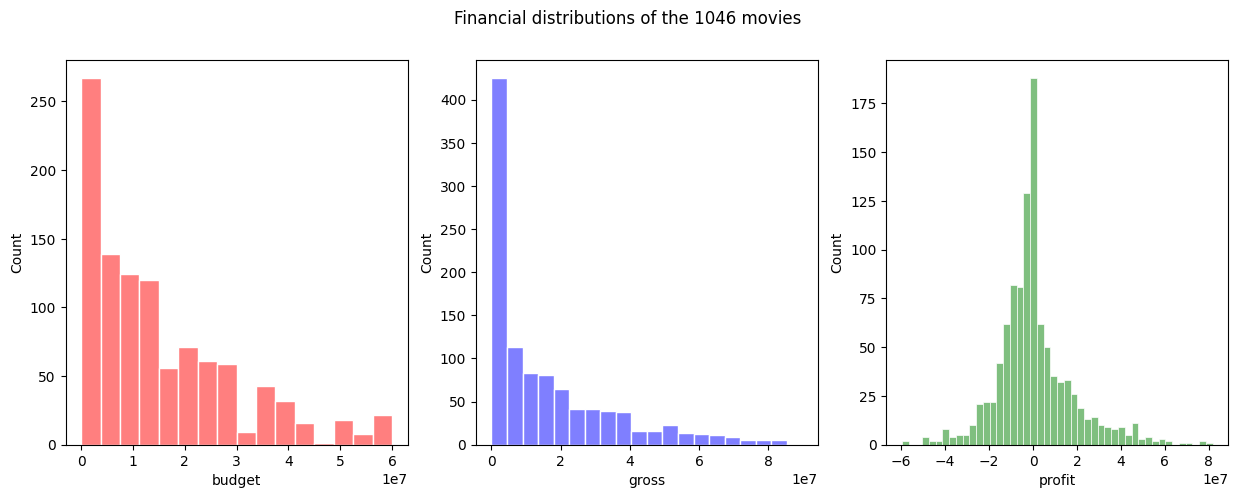

,budget,gross,profit
count,1046.0,1046.0,1046.0
mean,15357181.251434,15949503.660612,592322.409178
std,14503900.44725,19071006.471354,17600804.649789
min,218.0,703.0,-59768583.0
25%,3500000.0,1042200.75,-8928740.25
50%,11000000.0,8189048.5,-991797.5
75%,23000000.0,25031940.25,6783748.0
max,60000000.0,89808372.0,81700000.0
movie_highest,This Is It,"Legally Blonde 2: Red, White & Blonde",Pinocchio
movie_lowest,Tarnation,The Jimmy Show,The Swindle


In [87]:
# Initialize the class and prepare the data
steve = MDO_Statistician.from_directory("../data/")
steve.get_dist_financials(plot=True)

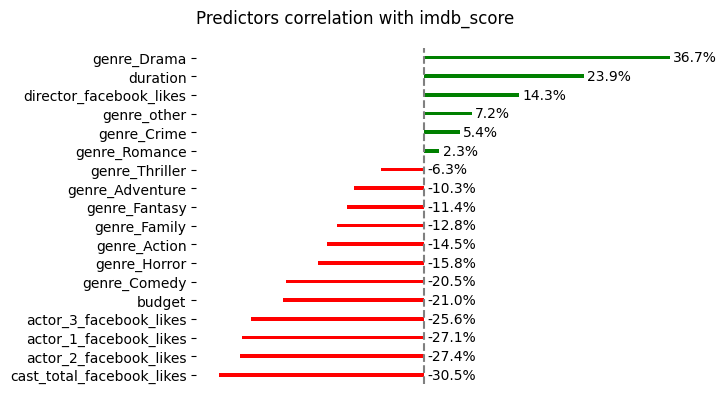

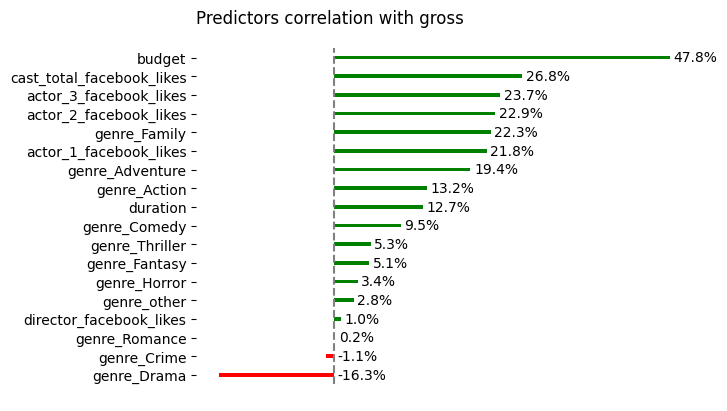

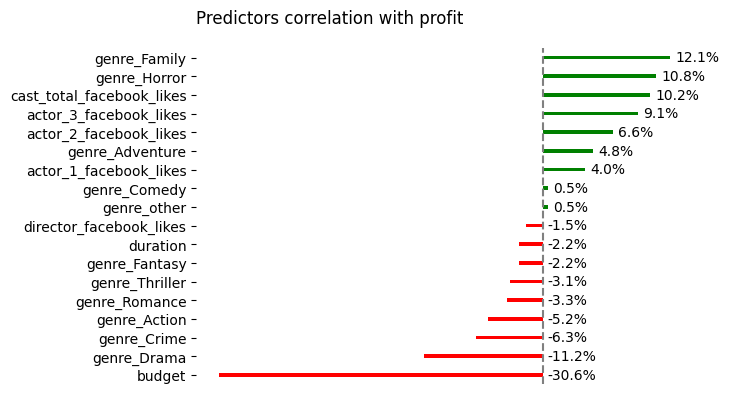

                F-stat imdb_score       p-value
content_rating           9.520236  2.962480e-15
director_name            2.273118  8.102686e-12
language                 3.987295  1.349641e-10
country                  3.402983  1.394862e-10
actor_1_name             1.566690  1.226842e-05
actor_2_name             1.192157  1.093015e-01
actor_3_name             1.093225  3.057109e-01
                F-stat gross       p-value
content_rating     11.976577  1.018929e-19
country             1.690067  7.158829e-03
language            1.689342  1.707702e-02
actor_2_name        1.265941  4.952431e-02
director_name       1.195913  5.993995e-02
actor_1_name        0.981425  5.799356e-01
actor_3_name        0.942536  6.622909e-01
                F-stat profit       p-value
content_rating       4.959931  4.821211e-07
country              1.930119  9.161153e-04
language             1.759645  1.097645e-02
actor_2_name         0.989161  5.457399e-01
actor_3_name         0.878423  8.085300e-01
director

In [88]:
# Are the financial and public success of a movie comming from the same factors?
_ = steve.get_correlation("imdb_score", plot=True)
_ = steve.get_correlation("gross", plot=True)
_ = steve.get_correlation("profit", plot=True)

print(steve.get_anova("imdb_score"))
print(steve.get_anova("gross"))
print(steve.get_anova("profit"))

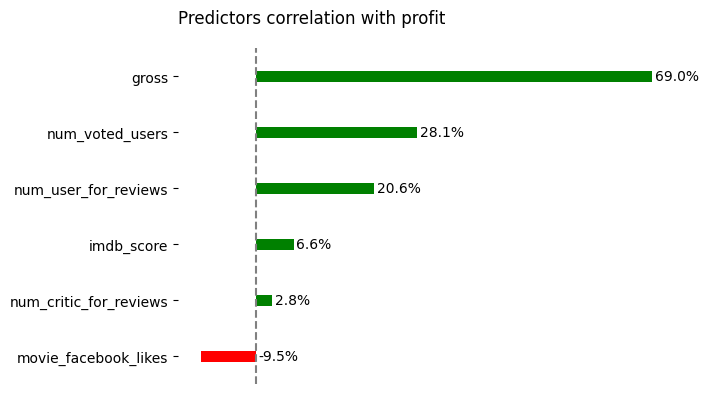

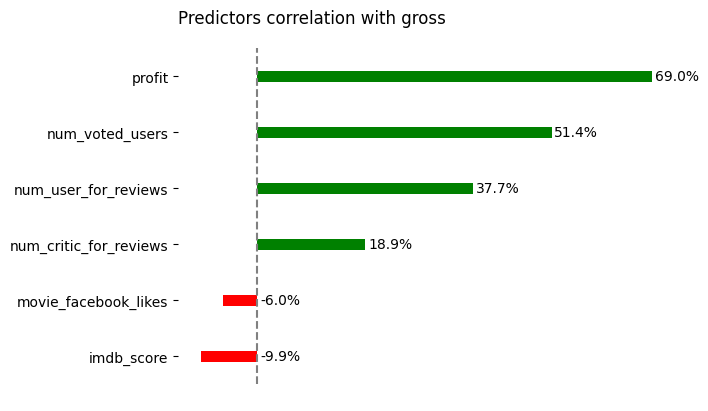

In [89]:
# Are the metrics of success correlated?
_ = steve.get_correlation(
    predictors=[col for col in steve.success_columns if col != "profit"],
    target="profit", plot=True)
_ = steve.get_correlation(
    predictors=[col for col in steve.success_columns if col != "gross"],
    target="gross", plot=True)

## The Agent

In [90]:
class MDO_Agent(MDO):
    """Second employee of the Movie Director Office, the agent knows his way around the movie industry.
    He can provide insights into directors, actors and their relationships.

    Base Class
    ----------
    MDO : MDO
        Base class for the Movie Director Office project

    Special Attributes
    ------------------
    top : int
        Number of top genres to keep chosen by the agent
    
    Special Methods
    ---------------

    """

    def __init__(self, pre:str = "../data/pre_release.csv", after:str = "../data/after_release.csv", top:int=10) -> None:
        super().__init__(pre, after)
        self.top = top
        self.prepare_data()
        self.split_genres(top=10)
        self.add_features()

    #># Method 1:

    def get_top_directors(self, top:int=5, sort_by:str="gross") -> pd.DataFrame:
        """Get the top directors based on a given criteria.

        Parameters
        ----------
        top : int, optional
            Number of directors to display, by default 5
        criteria : str, optional
            Criteria to sort the directors, by default "gross"
            Choose from "budget", "gross", "profit", "imdb_score" or "director_facebook_likes"

        Returns
        -------
        pd.DataFrame
            DataFrame with the top directors
        """

        # Define the information to gather for the directors
        criteria = ["budget", "gross", "profit", "imdb_score", "director_facebook_likes"]
        infos = ["director_name","movie_title", "language", "country"]
        genres = [col for col in self.full.columns if "genre_" in col]

        # Group by director and aggregate the information
        top_directors = self.full[criteria+infos+genres].groupby("director_name").agg({
            **{col:"mean" for col in criteria},
            "movie_title":"count", "language":pd.Series.mode, "country":pd.Series.mode,
            **{col:"sum" for col in genres}
        }).sort_values(by=sort_by, ascending=False).head(top)
        top_directors.columns = [
            "Average budget", "Average gross", "Average profit", "Average imdb score", "Average director facebook likes",
            "Number of movies", "Most common language", "Most common country", *genres
        ]

        # Return the top directors
        return top_directors
    
    #># Method 2:

    def get_info_celebrity(self, name:str, verbose:bool=True) -> dict:
        """Get information about a celebrity.

        Parameters
        ----------
        name : str
            Name of the celebrity (director or actor)
        verbose : bool, optional
            Display the information, by default True

        Returns
        -------
        dict
            Information about the celebrity
        """

        # Create the API URL
        api_url = 'https://api.api-ninjas.com/v1/celebrity?name={}'.format(name)

        # Use environment variable to keep the API KEY private when shared
        response = requests.get(api_url, headers={'X-Api-Key': os.environ.get("NINJA_API_KEY", None)})
        
        # Catch eventual failed requests
        if response.status_code == requests.codes.ok:
            details = (response.json()[0])
            if verbose:
                print(f"Here is all I know about {name}:")
                for key, value in details.items():
                    print(f"  - {key}: {value}")
            return details
        else:
            print(f"I'm sorry, I don't know much about {name}.")
            return {}

### Demo

In [93]:
josh = MDO_Agent()

display(josh.get_top_directors(3, "movie_title"))
display(josh.get_top_directors(3, "profit"))
display(josh.get_top_directors(3, "genre_Action"))


,Average budget,Average gross,Average profit,Average imdb score,Average director facebook likes,Number of movies,Most common language,Most common country,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_other
director_name,,,,,,,,,,,,,,,,,,,
Spike Lee,6.867857e+06,1.233011e+07,5.462248e+06,6.300,0.0,7,English,USA,5,6,1,0,0,0,0,0,0,0,4
Brian De Palma,1.462500e+07,1.498156e+07,3.565618e+05,6.400,0.0,4,English,USA,2,0,1,4,3,0,0,0,0,0,3
Barry Levinson,1.925000e+07,7.651720e+06,-1.159828e+07,6.275,272.0,4,English,USA,1,3,0,1,0,0,1,0,0,1,1


,Average budget,Average gross,Average profit,Average imdb score,Average director facebook likes,Number of movies,Most common language,Most common country,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_other
director_name,,,,,,,,,,,,,,,,,,,
Norman Ferguson,2600000.0,84300000.0,81700000.0,7.5,3.0,1,English,USA,0,0,0,0,0,0,0,0,1,1,1
Hugh Wilson,4500000.0,81200000.0,76700000.0,6.7,37.0,1,English,USA,0,1,0,0,0,0,0,0,0,0,0
Herbert Ross,8200000.0,80000000.0,71800000.0,6.5,71.0,1,English,USA,1,0,1,0,0,0,0,0,0,0,1


,Average budget,Average gross,Average profit,Average imdb score,Average director facebook likes,Number of movies,Most common language,Most common country,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_other
director_name,,,,,,,,,,,,,,,,,,,
John Glen,2.987500e+07,5.101323e+07,21138228.0,6.550000,46.0,4,English,UK,0,0,0,4,0,4,4,0,0,0,0
Lewis Gilbert,1.916667e+07,5.086667e+07,31700000.0,6.766667,43.0,3,English,UK,0,0,0,3,0,3,3,0,0,0,2
Les Mayfield,2.933333e+07,9.898363e+06,-19434970.0,5.333333,10.0,3,English,USA,0,2,0,0,2,3,0,0,0,0,1


In [92]:
# josh.get_info_celebrity("Bruce Willis")
# josh.get_info_cebrity("Quentin Tarantino")